# Topic Modelling

In [11]:
import os
import re
from pathlib import Path
from typing import List
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import polars as pl
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
import spacy
import torch
torch.set_num_threads(12)
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm

### Load constructed datasets

In [2]:
PATH_DATASET = "../results/pipeline/hotel_reviews_1/pet.csv"
PATH_DATASET_COMPLEMENTARY = "../results/pipeline/hotel_reviews_1/no_pet.csv"

In [3]:
df = pl.read_csv(PATH_DATASET, schema_overrides={"id": pl.Utf8})
df_complementary = pl.read_csv(PATH_DATASET_COMPLEMENTARY, schema_overrides={"id": pl.Utf8})

### Lemmatization of reviews

Statistical methods are based on word occurrence. To improve the robustness and consistency of the results, a lemmatization step of our reviews can/should be applied. The lemmatized review is then contained in a new column of the dataset, called review_lemmatized.

In [4]:
# Load spacy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])


def lemmatize_and_clean_texts(
    texts: List[str],
    batch_size: int = 2000,
    n_process: int = 4
) -> List[str]:
    clean_texts = [(t if isinstance(t, str) else "") for t in texts]
    lemmatized = []
    for doc in nlp.pipe(clean_texts, batch_size=batch_size, n_process=n_process):
        text = " ".join([token.lemma_ for token in doc])
        text = text.replace(" - ", "-").strip()
        lemmatized.append(text)
    return lemmatized


def lemmatize_column_fast(
    df: pl.DataFrame, 
    col_name: str, 
    new_col_name: str = None, 
    chunk_size: int = 50000, 
    n_process: int = 4
) -> pl.DataFrame:
    new_col_name = new_col_name or f"{col_name}_lemmatized"
    texts = df.select(col_name).to_series().to_list()
    lemmatized_chunks = []

    for i in tqdm(range(0, len(texts), chunk_size), desc=f"Lemmatizing {col_name}"):
        chunk = texts[i:i + chunk_size]
        lemmatized_chunks.extend(lemmatize_and_clean_texts(chunk, n_process=n_process))

    return df.with_columns(pl.Series(name=new_col_name, values=lemmatized_chunks))

In [5]:
df = lemmatize_column_fast(df, col_name="review_cleaned", new_col_name="review_lemmatized")
df_complementary = lemmatize_column_fast(df_complementary, col_name="review_cleaned", new_col_name="review_lemmatized")

Lemmatizing review_cleaned: 100%|██████████| 1/1 [00:26<00:00, 26.06s/it]


### Stop words

To reduce as much noise as possible in the reviews, we remove a predefined list of words known as stop words.
Stop words are very common words in English (e.g. “the”, “and”, “is”) that carry little semantic information and are unlikely to contribute to meaningful analysis.
In addition to standard stop word lists, this list can be customised by manually adding domain-specific or overly frequent terms in order to further improve the quality of the textual representations.

In [6]:
custom_stop_words = set(get_stop_words("en"))

extra_stop_words = {"didn", "amp", "quinta"} 
custom_stop_words.update(extra_stop_words)

custom_stop_words = list(custom_stop_words)

## TF-IDF

TF–IDF (Term Frequency–Inverse Document Frequency) is a text-weighting method that highlights how important a word is within a document relative to a collection of documents. It combines the frequency of a term in a document (TF) with its rarity across the corpus (IDF). As a result, very common words receive low weights, while more distinctive terms obtain higher scores. This makes TF–IDF particularly useful for identifying characteristic vocabulary within a dataset or a specific group of documents.

### Unigrams and Bigrams

Two complementary TF–IDF configurations are used in this project:

- **Unigrams** (`ngram_range=(1, 1)`), which capture individual keywords and provide a clear, interpretable overview of dominant terms.
- **Bigrams** (`ngram_range=(1, 2)`), which capture short word sequences and allow meaningful expressions to be identified (e.g. *“pet fee”*, *“service animal”*), rather than isolated words.

Using both representations helps balance interpretability and semantic expressiveness.

### Discriminative TF–IDF Ratio

Beyond computing TF–IDF scores on a single dataset, we introduce a **ratio-based variant** to identify terms that are particularly discriminative between two corpora.

Given:
- a target dataset (e.g. reviews from a specific traveller category),
- a comparison dataset (either its complementary set or another category),

we compute the average TF–IDF score of each term in both datasets and define a ratio:

$$
\text{ratio}(w) =
\frac{\text{TF-IDF}_{\text{category}}(w)}
{\max\left(\text{TF-IDF}_{\text{rest}}(w), \varepsilon\right)}
$$

This ratio highlights words that are not only frequent in the target dataset, but also significantly less present in the comparison set. It is therefore well suited for identifying **group-specific and discriminative vocabulary**, rather than globally frequent terms.

### Usage Guidelines

- The method can be applied to:
  - one dataset and its complementary set (e.g. *pet* vs. *non-pet* reviews),
  - or two datasets corresponding to two extracted traveller categories.
- The ratio-based analysis is particularly useful for:
  - comparing needs and concerns across traveller groups,
  - identifying vocabulary that truly differentiates one group from another.

### Configuration and Parameter Influence

Below is the core implementation used for TF–IDF and ratio-based analysis. The main configurable parameters and their effects are:

- **`stop_words`**  
  Removes common and domain-specific words to reduce noise and improve topic interpretability.

- **`min_df`**  
  Minimum number of documents a term must appear in to be considered.  
  Higher values remove very rare terms and improve robustness.

- **`max_df`**  
  Maximum proportion of documents a term can appear in.  
  Lower values remove overly frequent terms that carry little discriminative power.

- **`ngram_range`**  
  Controls whether unigrams, bigrams, or both are extracted.

- **`TOP_K`**  
  Number of top discriminative terms retained for analysis.

- **`RATIO_THRESHOLD`**  
  Minimum ratio required for a term to be considered discriminative.  
  Higher values yield more specific but fewer terms.

- **`EPS`**  
  Small constant to avoid division by zero when computing ratios.

```python
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words=custom_stop_words,
    min_df=5,
    max_df=0.9,
    ngram_range=(1, 1)  # use (1, 2) for bigrams
)
```

### Output Files and Interpretation

The TF–IDF analysis produces several output files for each comparison, stored in the corresponding results directory:

- **`*_tfidf.csv`**  
  Contains terms ranked by their average TF–IDF score in the target dataset.  
  This file highlights the most characteristic words or expressions of the analysed group.

- **`*_ratio.csv`**  
  Contains the full table of terms with their TF–IDF scores in both datasets and the corresponding ratio value.  
  This file is particularly useful for detailed inspection and custom filtering.

- **`*_discriminant.csv`**  
  Contains the top discriminative terms whose ratio exceeds the predefined threshold.  
  These terms represent vocabulary that is both frequent in the target dataset and significantly underrepresented in the comparison set.

In practice, TF–IDF scores should be interpreted as indicators of **representativeness**, while ratio-based results highlight **discriminative power** between datasets. Combining both perspectives provides a more robust understanding of group-specific language and underlying needs.



### For unigrams

In [7]:
# CONFIGURATION
CATEGORY_NAME = "pet"
OUTPUT_FOLDER = "../results/topic_modelling/TFIDF"
REVIEW_COL = "review_lemmatized"

TOP_K = 80
RATIO_THRESHOLD = 1.5
EPS = 1e-6

# VECTORIZER
vectorizer = TfidfVectorizer(
    stop_words=custom_stop_words,
    min_df=5,
    max_df=0.9,
    ngram_range=(1, 1)
)

# UTILITIES
def save_results(name: str, results: dict, output_folder: str):

    out_folder = Path(output_folder) / "unigrams_version"
    out_folder.mkdir(parents=True, exist_ok=True)

    # TF-IDF
    tfidf_rows = [
        {
            "group": name,
            "word": word,
            "tfidf_category": score
        }
        for word, score in results["tfidf"]
    ]

    pl.DataFrame(tfidf_rows).write_csv(out_folder / f"{name}_tfidf.csv")

    # RATIO
    results["ratio"].write_csv(out_folder / f"{name}_ratio.csv")

    # DISCRIMINANTS
    discr_rows = [
        {"group": name, "word": w}
        for w in results["discriminant"]
    ]

    pl.DataFrame(discr_rows).write_csv(out_folder / f"{name}_discriminant.csv")
    print(f"[{name}] Results saved")


def compute_tfidf_category_vs_rest(
    df_category: pl.DataFrame,
    df_rest: pl.DataFrame,
    review_col: str
):

    all_reviews = (
        df_category[review_col].to_list()
        + df_rest[review_col].to_list()
    )

    vectorizer.fit(all_reviews)

    X_cat = vectorizer.transform(df_category[review_col].to_list())
    tfidf_cat = X_cat.mean(axis=0).A1

    X_rest = vectorizer.transform(df_rest[review_col].to_list())
    tfidf_rest = X_rest.mean(axis=0).A1

    words = vectorizer.get_feature_names_out()

    rows = []
    for w, s_cat, s_rest in zip(words, tfidf_cat, tfidf_rest):
        rows.append({
            "word": w,
            "tfidf_category": float(s_cat),
            "tfidf_rest": float(s_rest),
            "ratio": float(s_cat / max(s_rest, EPS))
        })

    df_scores = (
        pl.DataFrame(rows)
        .sort("tfidf_category", descending=True)  
    )

    discriminant_words = (
        df_scores
        .filter(pl.col("ratio") >= RATIO_THRESHOLD)
        .head(TOP_K)["word"]
        .to_list()
    )

    tfidf_sorted = list(
        zip(
            df_scores["word"].to_list(),
            df_scores["tfidf_category"].to_list()
        )
    )

    return {
        "tfidf": tfidf_sorted,
        "ratio": df_scores,
        "discriminant": discriminant_words
    }


if __name__ == "__main__":

    df_category = df
    df_rest = df_complementary

    results = compute_tfidf_category_vs_rest(
        df_category=df_category,
        df_rest=df_rest,
        review_col=REVIEW_COL
    )

    save_results(
        name=f"{CATEGORY_NAME}",
        results=results,
        output_folder=OUTPUT_FOLDER
    )

    print("TF-IDF + ratio processing finished")


[pet] Results saved
TF-IDF + ratio processing finished


### For bigrams


In [8]:
# CONFIGURATION
CATEGORY_NAME = "pet"
OUTPUT_FOLDER = "../results/topic_modelling/TFIDF"
REVIEW_COL = "review_lemmatized"

TOP_K = 80
RATIO_THRESHOLD = 1.5
EPS = 1e-6

# VECTORIZER
vectorizer = TfidfVectorizer(
    stop_words=custom_stop_words,
    min_df=5,
    max_df=0.9,
    ngram_range=(2, 2)
)

def save_results(name: str, results: dict, output_folder: str):

    out_folder = Path(output_folder) / "bigrams_version"
    out_folder.mkdir(parents=True, exist_ok=True)

    tfidf_rows = [
        {
            "group": name,
            "word": word,
            "tfidf_category": score
        }
        for word, score in results["tfidf"]
    ]

    pl.DataFrame(tfidf_rows).write_csv(out_folder / f"{name}_tfidf.csv")

    results["ratio"].write_csv(out_folder / f"{name}_ratio.csv")

    discr_rows = [
        {"group": name, "word": w}
        for w in results["discriminant"]
    ]

    pl.DataFrame(discr_rows).write_csv(out_folder / f"{name}_discriminant.csv")
    print(f"[{name}] Results saved")


def compute_tfidf_category_vs_rest(
    df_category: pl.DataFrame,
    df_rest: pl.DataFrame,
    review_col: str
):
    all_reviews = (
        df_category[review_col].to_list()
        + df_rest[review_col].to_list()
    )

    vectorizer.fit(all_reviews)

    X_cat = vectorizer.transform(df_category[review_col].to_list())
    tfidf_cat = X_cat.mean(axis=0).A1

    X_rest = vectorizer.transform(df_rest[review_col].to_list())
    tfidf_rest = X_rest.mean(axis=0).A1

    words = vectorizer.get_feature_names_out()

    rows = []
    for w, s_cat, s_rest in zip(words, tfidf_cat, tfidf_rest):
        rows.append({
            "word": w,
            "tfidf_category": float(s_cat),
            "tfidf_rest": float(s_rest),
            "ratio": float(s_cat / max(s_rest, EPS))
        })

    df_scores = (
        pl.DataFrame(rows)
        .sort("tfidf_category", descending=True)  
    )

    discriminant_words = (
        df_scores
        .filter(pl.col("ratio") >= RATIO_THRESHOLD)
        .head(TOP_K)["word"]
        .to_list()
    )

    tfidf_sorted = list(
        zip(
            df_scores["word"].to_list(),
            df_scores["tfidf_category"].to_list()
        )
    )

    return {
        "tfidf": tfidf_sorted,
        "ratio": df_scores,
        "discriminant": discriminant_words
    }

if __name__ == "__main__":

    df_category = df
    df_rest = df_complementary

    results = compute_tfidf_category_vs_rest(
        df_category=df_category,
        df_rest=df_rest,
        review_col=REVIEW_COL
    )

    save_results(
        name=f"{CATEGORY_NAME}",
        results=results,
        output_folder=OUTPUT_FOLDER
    )

    print("TF-IDF + ratio processing finished")


[pet] Results saved
TF-IDF + ratio processing finished


## Non-Negative Matrix Factorization (NMF)

NMF (Non-Negative Matrix Factorization) is an unsupervised technique that factorizes a matrix into two smaller matrices with only non-negative coefficients. When applied to text, it can identify topics or recurring themes in a corpus of reviews by grouping words that often appear together. This is particularly useful for highlighting the recurring needs or preferences of travellers with special requirements.

### Workflow Overview

1. **TF–IDF Vectorization**  
   The reviews are first vectorized using a TF–IDF representation. In our pipeline, both unigrams and bigrams are considered (`ngram_range=(1, 2)`) to capture individual keywords and meaningful word sequences (e.g., *“pet fee”*, *“accessible room”*). Stop words are removed, and extreme terms are limited using `min_df` and `max_df`.

2. **NMF Model Fitting**  
   The vectorized review matrix is factorized using the NMF algorithm (`n_components = n_topics`), producing:
   - a **topic-term matrix**, which represents each topic as a weighted combination of words,
   - a **document-topic matrix**, which represents each review as a mixture of topics.

   The **dominant topic** for each review is obtained by selecting the topic with the highest weight in the document-topic matrix.

3. **UMAP + KDE Visualization**  
   To visualize the topics in a low-dimensional space, we apply UMAP to the TF–IDF vectors and overlay a KDE plot for each topic.  
   - The **scatter plot** shows the position of each review.  
   - **KDE contours** highlight the density of reviews per topic.  
   - **Centroids** of topics are marked with red stars and labeled with topic IDs.

### Key Parameters

- **`n_topics_default`** – Number of topics to extract. Automatically adjusted if the number of reviews is smaller than this value.
- **`n_top_words`** – Number of top words displayed per topic.
- **`min_df` / `max_df` (TF–IDF vectorizer)** – Control the inclusion of rare or overly common words.
- **`ngram_range`** – Determines whether unigrams, bigrams, or both are included.
- **`MIN_POINTS_FOR_KDE`** – Minimum number of reviews required to plot a KDE for a topic.
- **`max_features`** – Maximum number of features used by TF–IDF to limit memory consumption.

### Output Files

The pipeline produces the following outputs in `../results/topic_modelling/NMF`:

- **`*_nmf_topics.csv`**  
  Contains each review with its **dominant topic** and a label combining the category and topic ID (`cat_topic`).  
  Example columns: `review_lemmatized | dominant_topic | cat_topic`.

- **`*_nmf_top_words.txt"`**  
  Lists the **most important words for each topic**, with their NMF weight. This helps interpret the themes captured by each topic (e.g., *“pet fee”*, *“breakfast”*, *“accessible room”*).

- **`*_nmf_topics_plot.png`**  
  UMAP scatter plot of all reviews with KDE contours for topics. Red stars indicate topic centroids. This provides a **visual overview of topic separation and density** in the dataset.

### Interpretation

- **Topic-term matrix**: High-weight words define the theme of each topic.
- **Document-topic matrix**: Shows how strongly each review belongs to each topic.  
- **Dominant topic**: Useful for summarizing or aggregating reviews by theme.
- **UMAP + KDE plot**: Reveals clusters of similar reviews and helps validate the coherence of topics.

By combining NMF with TF–IDF and UMAP, this pipeline allows both **quantitative analysis** (topic distribution, top words) and **visual inspection**, providing a clear view of recurring patterns in reviews from travellers with specific needs.


[INFO] NMF topics CSV exported to: ..\results\topic_modelling\NMF\pet_nmf_topics.csv

===== TOP WORDS PER TOPIC =====

--- Topic 0 ---
staff (1.340)
helpful (0.693)
clean (0.685)
staff friendly (0.643)
stay (0.629)
friendly helpful (0.460)
friendly (0.452)
friendly staff (0.342)
accommodate (0.315)
time (0.295)
------------------------------
--- Topic 1 ---
pet friendly (1.067)
pet (1.054)
friendly (0.881)
friendly clean (0.118)
hotel pet (0.106)
friendly staff (0.074)
friendly pet (0.063)
friendly dog (0.061)
friendly hotel (0.059)
friendly love (0.059)
------------------------------
--- Topic 2 ---
hotel (1.365)
friendly hotel (0.381)
travel (0.256)
stay (0.222)
hotel pet (0.216)
dog (0.193)
stay hotel (0.179)
hotel dog (0.179)
hotel stay (0.156)
policy (0.140)
------------------------------
--- Topic 3 ---
dog (1.076)
love (0.970)
dog friendly (0.606)
friendly (0.294)
location (0.250)
love dog (0.247)
friendly love (0.180)
dog love (0.127)
hotel dog (0.127)
travel dog (0.101)
------

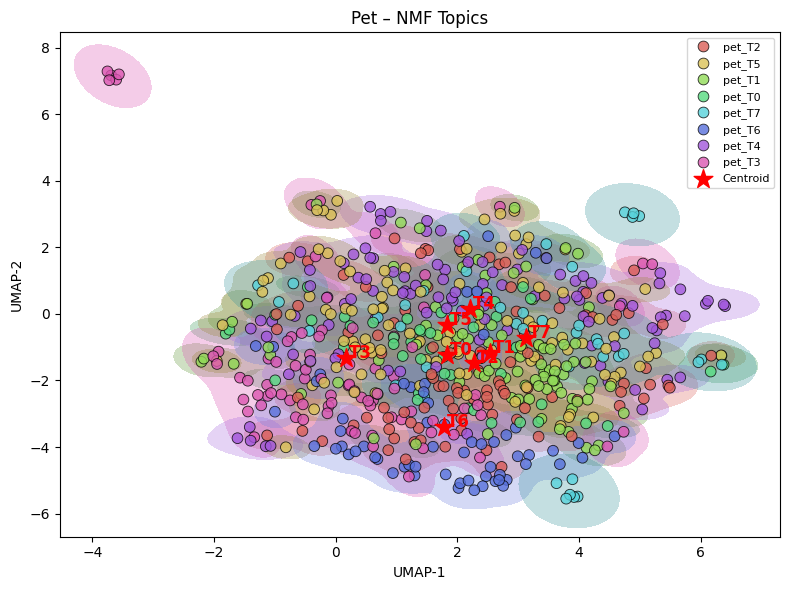

In [9]:
# CONFIGURATION
CATEGORY_NAME = "pet"
OUTPUT_FOLDER = "../results/topic_modelling/NMF"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

n_topics_default = 8
n_top_words = 10
MIN_POINTS_FOR_KDE = 3


def fit_nmf(df: pl.DataFrame, vectorizer: TfidfVectorizer, n_topics: int):

    reviews = df["review_lemmatized"].to_list()
    n_topics_cat = min(n_topics, len(reviews))
    n_topics_cat = max(n_topics_cat, 1) 

    X_cat = vectorizer.transform(reviews)
    nmf_model = NMF(n_components=n_topics_cat, 
                    random_state=42, 
                    init="nndsvda", 
                    max_iter=1000).fit(X_cat)
    
    doc_topic_dist = nmf_model.transform(X_cat)
    dominant_topics = np.argmax(doc_topic_dist, axis=1)

    return dominant_topics, nmf_model, doc_topic_dist, X_cat


all_reviews = df["review_lemmatized"].to_list()
vectorizer = TfidfVectorizer(
    stop_words=custom_stop_words,
    ngram_range=(1, 2),
    lowercase=True,
    max_features=5000,
    min_df=5,
    max_df=0.8
)
X_global = vectorizer.fit_transform(all_reviews)
feature_names = vectorizer.get_feature_names_out()


# NMF MODEL
dominant_topics, nmf_model, doc_topic_dist, X_cat = fit_nmf(df, vectorizer, n_topics_default)

df_all = df.with_columns([
    pl.Series("dominant_topic", dominant_topics),
    pl.Series("cat_topic", [f"{CATEGORY_NAME}_T{t}" for t in dominant_topics])
])


output_csv_path = Path(OUTPUT_FOLDER) / f"{CATEGORY_NAME}_nmf_topics.csv"
df_all.write_csv(output_csv_path)
print(f"[INFO] NMF topics CSV exported to: {output_csv_path}")

top_words_txt_path = Path(OUTPUT_FOLDER) / f"{CATEGORY_NAME}_nmf_top_words.txt"

with open(top_words_txt_path, "w", encoding="utf-8") as f:
    print("\n===== TOP WORDS PER TOPIC =====\n")
    f.write("===== TOP WORDS PER TOPIC =====\n\n")
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_idx = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_idx]
        top_weights = topic[top_idx]
        
        print(f"--- Topic {topic_idx} ---")
        f.write(f"--- Topic {topic_idx} ---\n")
        
        for w, wt in zip(top_words, top_weights):
            print(f"{w} ({wt:.3f})")
            f.write(f"{w} ({wt:.3f})\n")
        
        print("------------------------------")
        f.write("------------------------------\n")

print(f"[INFO] Top words per topic saved to: {top_words_txt_path}")


# UMAP + KDE PLOT
reducer = umap.UMAP(
    n_neighbors=min(10, len(df)-1),
    min_dist=0.5,
    random_state=42
)
X_embedded = reducer.fit_transform(X_global)

df_plot = pd.DataFrame({
    "x": X_embedded[:, 0],
    "y": X_embedded[:, 1],
    "cat_topic": df_all["cat_topic"].to_list(),
    "dominant_topic": df_all["dominant_topic"].to_list()
})

plt.figure(figsize=(8, 6))

unique_cat_topics = df_plot["cat_topic"].unique()
palette_colors = sns.color_palette("hls", n_colors=len(unique_cat_topics))
color_map = dict(zip(unique_cat_topics, palette_colors))

for group_name, group_data in df_plot.groupby("cat_topic"):
    if len(group_data) >= MIN_POINTS_FOR_KDE:
        sns.kdeplot(
            data=group_data,
            x="x",
            y="y",
            fill=True,
            levels=2,
            linewidths=2,
            alpha=0.3,
            color=color_map[group_name],
            bw_adjust=0.3,
            zorder=1
        )

sns.scatterplot(
    data=df_plot,
    x="x",
    y="y",
    hue="cat_topic",
    palette=color_map,
    s=60,
    alpha=0.8,
    edgecolor="k",
    zorder=2
)

topic_centers = df_plot.groupby('cat_topic')[['x', 'y']].mean().reset_index()
plt.scatter(topic_centers['x'], topic_centers['y'], color='red', s=200, marker='*', label='Centroid', zorder=3)
for idx, row in topic_centers.iterrows():
    topic_id = int(row['cat_topic'].split("_T")[-1])
    plt.text(row['x'] + 0.05, row['y'], f"T{topic_id}", fontsize=12, weight='bold', color='red')

plt.title(f"{CATEGORY_NAME.capitalize()} – NMF Topics")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(fontsize=8)
plt.tight_layout()

fig_path = Path(OUTPUT_FOLDER) / f"{CATEGORY_NAME}_nmf_topics_plot.png"
plt.savefig(fig_path, bbox_inches="tight")
print(f"[INFO] NMF topics plot saved to: {fig_path}")
plt.show()


## LDA

## LDA Topic Modeling

LDA (Latent Dirichlet Allocation) is a probabilistic topic modeling technique that represents each document as a mixture of latent topics, and each topic as a distribution over words. Applied to travel reviews, LDA can uncover **recurring themes and concerns** expressed by travellers in a semi-unsupervised manner. This is particularly useful to identify needs specific to certain groups, such as travellers with pets or children.

### Workflow Overview

1. **Text Preprocessing**
   - Reviews are lowercased and cleaned to remove non-alphabetic characters.
   - Tokens are filtered using both **general English stopwords** (from NLTK) and a **custom list** of corpus-specific stopwords (e.g., `"dog"`, `"pet"`, `"hotel"`) to remove overly frequent or uninformative words.
   - Optionally, bigrams are constructed to capture multi-word expressions like `"pet fee"` or `"accessible room"`.

2. **Dictionary and Corpus Creation**
   - A **gensim dictionary** is created from the preprocessed tokens, mapping each unique token to an integer ID.
   - Each document is converted into a **bag-of-words (BoW) representation**, indicating the frequency of each token in the document.

3. **LDA Model Fitting**
   - The LDA model is trained on the corpus with the following key parameters:
     - `num_topics` – Number of topics to extract (default 8).  
     - `passes` – Number of iterations over the corpus (more passes improve convergence).  
     - `alpha` – Document-topic prior, controlling topic sparsity (`'auto'` lets the model learn an optimal value).  
     - `random_state` – Ensures reproducible results.  
   - The output includes:
     - **topic-word distributions**, showing the importance of each word in each topic,
     - **document-topic distributions**, indicating the mixture of topics in each review.

4. **Dominant Topic Assignment**
   - For each review, the topic with the **highest probability** in its distribution is assigned as the dominant topic.  
   - This allows easy aggregation of reviews by topic and thematic analysis.

5. **Optional Visualization**
   - The `pyLDAvis` library generates an interactive visualization of topics:
     - Distance between topics in the 2D plane indicates semantic similarity.
     - Bar charts show the most relevant words per topic.
   - This helps **validate topic coherence** and explore the structure of the corpus.

### Key Parameters and Their Influence

| Parameter | Description | Influence |
|-----------|-------------|-----------|
| `num_topics` | Number of topics to extract | Too few topics → overly broad themes; too many topics → fragmented, less interpretable topics |
| `passes` | Number of iterations over corpus | More passes improve convergence but increase computation time |
| `alpha` | Document-topic prior | Lower values → documents focused on fewer topics; higher values → documents mix more topics |
| `min_count` / `threshold` (for bigrams) | Minimum frequency and threshold to form bigrams | Controls inclusion of meaningful multi-word expressions |
| Custom stopwords | Words removed before modeling | Reduces dominance of frequent, uninformative words (e.g., `"dog"`, `"pet"`) to highlight subtler themes |

### Output Files

The LDA pipeline produces the following outputs in `../results/topic_modelling/LDA`:

- **`lda_topics.csv`**  
  Contains the original reviews along with their **dominant topic assignment** (`dominant_topic_LDA`).  
  Useful for aggregating reviews by theme or comparing topic distributions across categories.

- **`lda_topics_top_words.csv`**  
  Contains the **top words per topic** with their LDA weights.  
  These words define each topic and help interpret the semantic meaning behind each cluster.

- **`lda_visualisation.html`**   
  Interactive visualization of the topic model using `pyLDAvis`.  
  Allows exploration of topic relationships and top words in a 2D layout.

### Interpretation

- **Dominant topics**: Summarize the main theme of each review.  
- **Top words per topic**: Highlight the key terms defining each topic; useful for labeling topics (e.g., *“pet fee”*, *“breakfast”*, *“room cleanliness”*).  
- **Visualization**: Provides an intuitive overview of topic separation, coherence, and relative importance.

By combining preprocessing, LDA modeling, and visualization, this pipeline allows both **quantitative and qualitative insights** into recurring themes in traveller reviews, including the needs and constraints of special traveller groups.


In [21]:
# CONFIGURATION
OUTPUT_FOLDER = "../results/topic_modelling/LDA"
NUM_TOPICS = 8  
TOP_WORDS = 10   

# Stopwords customized 
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
corpus_stopwords_LDA = ["dog","pet", "hotel", "room", "stay", "friendly", "clean", "staff", "la", "quinta"]

def preprocess_text(text):
    if text is None:
        return []
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words and w not in corpus_stopwords_LDA]
    return tokens

def get_dominant_topic(lda_model, bow):
    topics = lda_model.get_document_topics(bow)
    if topics:
        return max(topics, key=lambda x: x[1])[0]
    return None


texts = df["review_lemmatized"].to_list()
tokens_list = [preprocess_text(t) for t in texts]

bigram = Phrases(tokens_list, min_count=5, threshold=10)
bigram_mod = Phraser(bigram)
tokens_list_bigrams = [bigram_mod[doc] for doc in tokens_list]

dictionary = corpora.Dictionary(tokens_list_bigrams)
corpus = [dictionary.doc2bow(text) for text in tokens_list_bigrams]

# LDA MODEL
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=20,      
    alpha='auto',
    per_word_topics=True
)

# DOMINANT TOPIC PER DOCUMENT
dominant_topics = [get_dominant_topic(lda_model, bow) for bow in corpus]
df = df.with_columns(
    pl.Series(name="dominant_topic_LDA", values=dominant_topics)
)

# SAVE RESULTS
output_dir = Path(OUTPUT_FOLDER)
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "lda_topics.csv"
df.write_csv(output_file)
print(f"Dominant topics saved to {output_file}")

topic_words_list = []
for idx, topic in lda_model.show_topics(num_topics=NUM_TOPICS, num_words=TOP_WORDS, formatted=False):
    for word, weight in topic:
        topic_words_list.append({
            "topic": idx,
            "word": word,
            "weight": weight
        })

df_topics = pl.DataFrame(topic_words_list)
df_topics_file = output_dir / "lda_topics_top_words.csv"
df_topics.write_csv(df_topics_file)
print(f"Top words per topic saved to {df_topics_file}")

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

lda_visualisation_path = output_dir / "lda_visualisation.html"
pyLDAvis.save_html(vis,str(lda_visualisation_path))
print("LDA visualization saved as HTML")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dominant topics saved to ..\results\topic_modelling\LDA\lda_topics.csv
Top words per topic saved to ..\results\topic_modelling\LDA\lda_topics_top_words.csv
LDA visualization saved as HTML


## BERTopic

BERTopic is a modern topic modeling technique that combines **transformer-based embeddings**, **dimensionality reduction**, and **density-based clustering** to identify coherent topics in a corpus. Compared to traditional methods like LDA or NMF, BERTopic can capture **semantic similarities** between documents more effectively and handles large and noisy datasets well.

It is particularly useful for analyzing **reviews or feedback** to extract recurring themes and detect subtle distinctions between topics.

---

### Workflow Overview

1. **Data Preprocessing**
   - Reviews are lemmatized and cleaned.
   - Stopwords are removed using both **standard English stopwords** (NLTK) and a **custom list** for domain-specific frequent words (`"dog"`, `"pet"`, `"hotel"`, `"room"`).
   - Very short documents (less than 5 characters) are filtered out to improve clustering quality.

2. **BERTopic Components Configuration**
   BERTopic relies on several key components:

   **a. Embeddings**  
   - `SentenceTransformer` (`all-distilroberta-v1`) converts each document into a dense vector representing its semantic meaning.  
   - Using embeddings allows the model to group documents **based on meaning rather than just shared words**.

   **b. Dimensionality Reduction (UMAP)**  
   - Reduces high-dimensional embeddings to a lower-dimensional space for clustering.  
   - Key parameters:
     - `n_neighbors` – More neighbors → broader, smoother topics.  
     - `n_components` – Final embedding dimension (typical: 5–15).  
     - `min_dist` – Minimum distance between points in embedding space.  

   **c. Clustering (HDBSCAN)**  
   - Clusters documents in the reduced embedding space.
   - Key parameters:
     - `min_cluster_size` – Minimum size of a topic (↑ = fewer topics, broader).  
     - `min_samples` – Minimum points to form a core cluster point.  
     - `cluster_selection_method` – `'eom'` or `'leaf'`, affects how clusters are selected.  

   **d. Vectorization (CountVectorizer)**  
   - Extracts representative words for each topic.
   - Key parameters:
     - `ngram_range` – Capture unigrams and bigrams.  
     - `max_features` – Limit vocabulary size.  
     - `min_df` / `max_df` – Control rare and overly frequent terms.

---

### Training the Model

- BERTopic combines the embeddings, UMAP, HDBSCAN, and CountVectorizer to identify topics.
- `nr_topics="auto"` allows automatic determination of the optimal number of topics.
- `calculate_probabilities=False` speeds up training by skipping probability estimation.
- The result is:
  - `topics` – Assigned topic for each document.
  - `probabilities` – Topic probabilities (optional if enabled).

---

### Key Parameters and Their Influence

| Parameter | Description | Influence |
|-----------|-------------|-----------|
| `embedding_model` | Transformer model to encode text | Better embeddings → more semantically coherent topics |
| `UMAP.n_neighbors` | Number of neighbors for manifold learning | Higher values → smoother embeddings → broader topics |
| `UMAP.n_components` | Dimensionality of reduced space | Lower → more compressed, may lose subtle distinctions |
| `UMAP.min_dist` | Minimum distance between points | Lower → tighter clusters; higher → more spread |
| `HDBSCAN.min_cluster_size` | Minimum points to form a topic | Higher → fewer, larger topics; lower → more, smaller topics |
| `vectorizer_model.ngram_range` | Consider unigrams/bigrams | Bigrams capture multi-word expressions relevant to domain |
| `nr_topics` | Number of final topics | `"auto"` lets BERTopic merge small clusters into larger topics |

---

### Output Files

The BERTopic pipeline generates several outputs:

1. **Dominant Topic per Document**  
   - Array of topic IDs (`topics`) for each review.  
   - Outliers are labeled `-1` (documents that do not fit any topic).

2. **Topic Information** (`topic_info_handicap.csv`)  
   - Metadata for each topic:
     - Topic ID, number of documents, top words, etc.
   - Useful for labeling and interpreting each topic.

3. **Visualizations** (interactive HTML):
   - `bertopic_map_pet_hotel_1_new.html` → Interactive 2D map of topics.
   - `bertopic_hierarchy_pet_hotel_1_new.html` → Topic hierarchy tree.
   - `bertopic_barchart_pet_hotel_1_new.html` → Bar chart of top words/topics.
   - `bertopic_heatmap_pet_hotel_1_new.html` → Heatmap of topic similarities.

4. **Saved Model** (`bertopic_model/`)  
   - Allows reloading the trained BERTopic model without retraining.

---

### Interpretation

- **Topics**: Each cluster represents a recurring theme in the reviews.  
- **Top words per topic**: Describe the main content and semantic meaning of the topic.  
- **Outliers**: Documents not strongly related to any topic; often short, unclear, or off-topic reviews.  
- **Visualizations**: Provide a **global view of topic distribution**, coherence, and similarities.  

This workflow allows both **quantitative analysis** (number of documents per topic, key words) and **qualitative exploration** (semantic relations, hierarchy, outliers), making BERTopic particularly effective for travel review analysis.


In [13]:
# STEP 1: LOAD AND PREPARE DATA

print("Loading and preparing data")

def remove_stopwords(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return " ".join(word for word in text.split() if word not in custom_stop_words)

df = df.with_columns(
    pl.col("review_lemmatized")
      .map_elements(remove_stopwords)
      .alias("review_lemmatized_no_stopwords")
)

documents = df["review_lemmatized_no_stopwords"].to_list()
cleaned_corpus = documents.copy() 

# Filter out very short documents (>5)
documents = [doc for doc in documents if isinstance(doc, str) and len(doc.strip()) > 5]

print(f"{len(documents)} documents loaded, lemmatized, and stopwords removed")


Loading and preparing data
649 documents loaded, lemmatized, and stopwords removed


In [14]:
# STEP 2: BERTopic COMPONENT CONFIGURATION

print("\nConfiguring BERTopic model components")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

embedding_model = SentenceTransformer(
    "sentence-transformers/all-distilroberta-v1",
    device=device  
)

# Dimensionality Reduction with UMAP
umap_model = UMAP(
    n_neighbors=15,         
    n_components=5,         
    min_dist=0.0,           
    metric='cosine',        
    random_state=42,        
    n_jobs=1                
)

# Clustering with HDBSCAN
hdbscan_model = HDBSCAN(
    min_cluster_size=15,         
    min_samples=5,               
    metric='euclidean',         
    cluster_selection_method='eom', 
    prediction_data=True        
)

# Document Vectorization
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),     
    stop_words=None,          
    min_df=1,                 
    max_df=0.99,           
    max_features=5000
)

vectorizer_model.fit(cleaned_corpus)


Configuring BERTopic model components
Using device: cuda


,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None
,"stop_words stop_words: {'english'}, list, default=NoneIf 'english', a built-in stop word list for English is used.There are several known issues with 'english' and you shouldconsider an alternative (see :ref:`stop_words`).If a list, that list is assumed to contain stop words, all of whichwill be removed from the resulting tokens.Only applies if ``analyzer == 'word'``.If None, no stop words will be used. In this case, setting `max_df`to a higher value, such as in the range (0.7, 1.0), can automatically detectand filter stop words based on intra corpus document frequency of terms.",None
,"token_pattern token_pattern: str or None, default=r""(?u)\\b\\w\\w+\\b""Regular expression denoting what constitutes a ""token"", only usedif ``analyzer == 'word'``. The default regexp select tokens of 2or more alphanumeric characters (punctuation is completely ignoredand always treated as a token separator).If there is a capturing group in token_pattern then thecaptured group content, not the entire match, becomes the token.At most one capturing group is permitted.",'(?u)\\b\\w\\w+\\b'
,"ngram_range ngram_range: tuple (min_n, max_n), default=(1, 1)The lower and upper boundary of the range of n-values for differentword n-grams or char n-grams to be extracted. All values of n suchsuch that min_n <= n <= max_n will be used. For example an``ngram_range`` of ``(1, 1)`` means only unigrams, ``(1, 2)`` meansunigrams and bigrams, and ``(2, 2)`` means only bigrams.Only applies if ``analyzer`` is not callable.","(1, ...)"
,"analyzer analyzer: {'word', 'char', 'char_wb'} or callable, default='word'Whether the feature should be made of word n-gram or charactern-grams.Option 'char_wb' creates character n-grams only from text insideword boundaries; n-grams at the edges of words are padded with space.If a callable is passed it is used to extract the sequence of featuresout of the raw, unprocessed input... versionchanged:: 0.21Since v0.21, if ``input`` is ``filename`` or ``file``, the data isfirst read from the file and then passed to the given callableanalyzer.",'word'


In [15]:
# STEP 3: TRAINING THE BERTopic MODEL

print("\nTraining the BERTopic model")

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,             
    language="english",       
    calculate_probabilities=False,
    verbose=True,
    nr_topics="auto"      
)

topics, probabilities = topic_model.fit_transform(documents)

print(f"\nModel trained {len(set(topics)) - 1} topics found")
print(f"   (Topic -1 = outliers: {sum(1 for t in topics if t == -1)} documents)")

2026-01-13 21:27:32,891 - BERTopic - Embedding - Transforming documents to embeddings.



Training the BERTopic model


Batches: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]
2026-01-13 21:27:33,808 - BERTopic - Embedding - Completed ✓
2026-01-13 21:27:33,809 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-13 21:27:34,995 - BERTopic - Dimensionality - Completed ✓
2026-01-13 21:27:34,997 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-13 21:27:35,017 - BERTopic - Cluster - Completed ✓
2026-01-13 21:27:35,018 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-01-13 21:27:35,047 - BERTopic - Representation - Completed ✓
2026-01-13 21:27:35,048 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 21:27:35,052 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 21:27:35,078 - BERTopic - Representation - Completed ✓
2026-01-13 21:27:35,080 - BERTopic - Topic reduction - Reduced number of topics from 4 to 4



Model trained 3 topics found
   (Topic -1 = outliers: 9 documents)


In [16]:
# STEP 4: ANALYSIS OF TOPIC MODEL RESULTS

print("\nTop keywords per topic:")
for topic_id in range(min(10, len(set(topics)) - 1)): 
    words = topic_model.get_topic(topic_id)
    if words:
        keywords = ", ".join([word for word, score in words[:10]])
        count = sum(1 for t in topics if t == topic_id)
        print(f"  Topic {topic_id} ({count} docs): {keywords}")


Top keywords per topic:
  Topic 0 (595 docs): friendly, hotel, pet friendly, breakfast, nice
  Topic 1 (27 docs): hotel, alexandria, town, dc, town alexandria
  Topic 2 (18 docs): hotel, monaco, kimpton, hotel monaco, restaurant


In [18]:
# STEP 5: VISUALIZATIONS

OUTPUT_FOLDER = "../results/topic_modelling/BERTopic"
Path(OUTPUT_FOLDER).mkdir(exist_ok=True)

try:
    # Interactive topic map
    fig1 = topic_model.visualize_topics()
    fig1_path = Path(OUTPUT_FOLDER) / "bertopic_map.html"
    fig1.write_html(fig1_path)
    print(f"    Topic map saved: {fig1_path}")
    
    # Topic hierarchy
    fig2 = topic_model.visualize_hierarchy()
    fig2_path = Path(OUTPUT_FOLDER) / "bertopic_hierarchy.html"
    fig2.write_html(fig2_path)
    print(f"    Topic hierarchy saved: {fig2_path}")
    
    # Topic barchart
    fig3 = topic_model.visualize_barchart(top_n_topics=20)
    fig3_path = Path(OUTPUT_FOLDER) / "bertopic_barchart.html"
    fig3.write_html(fig3_path)
    print(f"    Barchart saved: {fig3_path}")
    
    # Topic similarity heatmap
    fig4 = topic_model.visualize_heatmap()
    fig4_path = Path(OUTPUT_FOLDER) / "bertopic_heatmap.html"
    fig4.write_html(fig4_path)
    print(f"    Heatmap saved: {fig4_path}")

except Exception as e:
    print(f" Error during visualization: {e}")


    Topic map saved: ..\results\topic_modelling\BERTopic\bertopic_map.html
    Topic hierarchy saved: ..\results\topic_modelling\BERTopic\bertopic_hierarchy.html
    Barchart saved: ..\results\topic_modelling\BERTopic\bertopic_barchart.html
    Heatmap saved: ..\results\topic_modelling\BERTopic\bertopic_heatmap.html
